## Idea

Decay the number_of_searches as valid_moves being less.

How to create 8 congruent-state child node at each expansion?

## Changes in 02_2

Adapt new terminal condition and get valid moves methods from 06_3 version. You can notice the iteration time is decreasing at the output of last code block.

In [1]:
import numpy as np
print(np.__version__)
np.random.seed(0)

import math
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import random

from numba import njit
import time

# JIT-compiled function to check if three points are collinear
@njit(cache=True)
def are_collinear(p1, p2, p3):
    """Returns True if the three points are collinear."""
    """Adapt from https://github.com/kitft/funsearch"""
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    return (y1 - y2) * (x1 - x3) == (y1 - y3) * (x1 - x2)

class N3il:  # Class for the No-Three-In-Line problem
    def __init__(self, grid_size):
        self.row_count = grid_size[0]
        self.column_count = grid_size[1]
        self.pts_upper_bound = np.min(grid_size)*2
        self.action_size = self.row_count * self.column_count

    def get_initial_state(self):
        # Return a grid of zeros representing an empty board
        return np.zeros((self.row_count, self.column_count))

    def get_next_state(self, state, action):
        # Place a point at the specified action (row-major order)
        row = action // self.column_count
        column = action % self.column_count
        state[row, column] = 1
        return state

    def get_valid_moves(self, state):
        """
        Return a flattened array where 1 indicates a valid move (empty and no collinearity),
        and 0 indicates an invalid move.
        """
        valid_mask = np.zeros((self.row_count, self.column_count), dtype=np.uint8)  # start with all invalid
        coords = np.argwhere(state == 1)
        existing_pairs = list(combinations(coords, 2))

        for i in range(self.row_count):
            for j in range(self.column_count):
                if state[i, j] != 0:
                    continue
                candidate = (i, j)
                if any(are_collinear(p1, p2, candidate) for p1, p2 in existing_pairs):
                    continue
                valid_mask[i, j] = 1  # 1 means valid

        return valid_mask.reshape(-1)

    def get_valid_moves_subset(self, parent_state, parent_valid_moves, action_taken):
        """
        Given a parent state and its valid move mask, return a refined valid move mask for the child:
        1) Remove the action just taken.
        2) For each remaining valid move, check if it forms a collinear triple with the new point and any existing point.
        Returns a flattened uint8 array: 1 = valid, 0 = invalid.
        """
        valid = parent_valid_moves.copy()
        valid[action_taken] = 0  # Remove the move just taken

        # Get all existing points from the parent state
        existing_points = [tuple(pt) for pt in np.argwhere(parent_state == 1)]

        # Get the coordinates of the new point that was just played
        new_row = action_taken // self.column_count
        new_col = action_taken % self.column_count
        new_point = (new_row, new_col)

        # For each candidate move that is still marked valid
        for act in np.where(valid == 1)[0]:
            cand_row = act // self.column_count
            cand_col = act % self.column_count
            candidate = (cand_row, cand_col)

            # Check collinearity with the new point and any existing point
            for pt in existing_points:
                if are_collinear(pt, new_point, candidate):
                    valid[act] = 0  # Mark invalid
                    break

        return valid  # 1D array (flattened)

    def check_collinear(self, state, action=None):
        # Check how many new collinear triples are formed by adding a new point

        if action is None:
            state_next = state
        else:
            row = action // self.column_count
            column = action % self.column_count
            state_next = state.copy()
            state_next[row, column] = 1

        coords = np.argwhere(state_next == 1)
        triples = list(combinations(coords, 3))

        number_of_collinear_triples = 0
        for triple in triples:
            if are_collinear(triple[0], triple[1], triple[2]):
                number_of_collinear_triples += 1

        return number_of_collinear_triples

    def get_value_and_terminated(self, state, valid_moves):
        # Return total number of points and whether a terminal condition is met
        if np.sum(valid_moves) > 0:
            return 0, False
        value = np.sum(state.reshape(-1) == 1) / self.pts_upper_bound # Normalization
        return value, True
    
    def get_encoded_state(self, state):
        encoded_state = np.stack(
            (state == 0, state == 1)
        ).astype(np.float32)
        
        return encoded_state

    def display_state(self, state, action_prob=None):
        """
        Display the current grid configuration using matplotlib.
        Points are drawn where the state equals 1.
        The origin (0, 0) is located at the bottom-left.
        If action_prob is provided (1D array), it is reshaped and overlaid as a heatmap.
        """
        plt.figure(figsize=(12, 12))
        ax = plt.gca()

        if action_prob is not None:
            assert action_prob.shape[0] == self.row_count * self.column_count, \
                f"Expected length {self.row_count * self.column_count}, got {len(action_prob)}"
            action_prob_2d = action_prob.reshape((self.row_count, self.column_count))
            flipped_probs = np.flipud(action_prob_2d)

            im = ax.imshow(
                flipped_probs,
                cmap='Reds',
                alpha=0.6,
                extent=[-0.5, self.column_count - 0.5, -0.5, self.row_count - 0.5],
                origin='lower',
                vmin=0, vmax=np.max(action_prob) if np.max(action_prob) > 0 else 1e-5
            )
            plt.colorbar(im, label="Action Probability", shrink=0.8)

            # Find maximum probability
            max_val = np.max(action_prob_2d)
            max_positions = np.argwhere(action_prob_2d == max_val)

            # Add text annotations for probabilities
            for i in range(self.row_count):
                for j in range(self.column_count):
                    val = action_prob_2d[i, j]
                    display_y = self.row_count - 1 - i  # Flip vertically
                    is_max = any((i == mp[0] and j == mp[1]) for mp in max_positions)
                    ax.text(
                        j, display_y, f"{val:.3f}",
                        ha="center", va="center",
                        color="gold" if is_max else ("black" if val < 0.5 * max_val else "white"),
                        weight='bold' if is_max else 'normal'
                    )

        # Plot placed points
        y_coords, x_coords = np.nonzero(state)
        flipped_y = self.row_count - 1 - y_coords
        plt.scatter(x_coords, flipped_y, s=100, c='blue', label='Placed Points')

        plt.grid(True)
        plt.xticks(range(self.column_count))
        plt.yticks(range(self.row_count))
        plt.xlim(-0.5, self.column_count - 0.5)
        plt.ylim(-0.5, self.row_count - 0.5)
        ax.set_aspect('equal')
        plt.title("No-Three-In-Line Grid with Action Probabilities" if action_prob is not None else "No-Three-In-Line Grid")
        plt.show()



'''
Adapt from
foersterrobert/AlphaZeroFromScratch
'''

class Node:
    def __init__(self, game, args, state, parent=None, action_taken=None):
        self.game = game
        self.args = args
        self.state = state
        self.parent = parent
        self.action_taken = action_taken

        self.children = []
        # self.expandable_moves = game.get_valid_moves(state)

        self.visit_count = 0
        self.value_sum = 0

        if parent is None:
            self.valid_moves = game.get_valid_moves(state)
        else:
            self.valid_moves = game.get_valid_moves_subset(
                parent.state, parent.valid_moves, self.action_taken)

    def is_fully_expanded(self):
        return np.sum(self.valid_moves) == 0 and len(self.children) > 0
    
    def select(self):
        best_child = None
        best_ucb = -np.inf

        for child in self.children:
            ucb= self.get_ucb(child)
            if ucb > best_ucb:
                best_child = child
                best_ucb = ucb
        
        return best_child
    
    def get_ucb(self, child):
        q_value = child.value_sum / child.visit_count
        return q_value + self.args['C'] * math.sqrt(math.log(self.visit_count) / child.visit_count)

    def expand(self):
        action = np.random.choice(np.where(self.valid_moves == 1)[0])
        self.valid_moves[action] = 0

        child_state = self.state.copy()
        child_state = self.game.get_next_state(child_state, action)

        child = Node(self.game, self.args, child_state, self, action)
        self.children.append(child)
        return child
    
    def simulate(self):
        # has_collinear = self.game.check_collinear(self.parent.state, self.action_taken)
        value, is_terminal = self.game.get_value_and_terminated(self.state, self.valid_moves)

        if is_terminal:
            # value, _ = self.game.get_value_and_terminated(self.parent.state)
            return value
            # return 0 # think about this part
        
        rollout_state = self.state.copy()

        while True:
            valid_moves = self.game.get_valid_moves(rollout_state)
            value, is_terminal = self.game.get_value_and_terminated(rollout_state, valid_moves)
            if is_terminal:
                # value, _ = self.game.get_value_and_terminated(rollout_state, valid_moves)
                return value
            action = np.random.choice(np.where(valid_moves == 1)[0])

            rollout_state = self.game.get_next_state(rollout_state, action)

    def backpropagate(self, value):
        self.value_sum += value
        self.visit_count += 1

        if self.parent is not None:
            self.parent.backpropagate(value)

class MCTS:
    def __init__(self, game, args={
        'num_searches': 1000,
        'C': 1.4
    }):
        self.game = game
        self.args = args

    def search(self, state):
        # define root
        root = Node(self.game, self.args, state)

        for search in trange(self.args['num_searches']):
            node = root

            # selection
            while node.is_fully_expanded():
                node = node.select()

            if node.action_taken is not None:
                value, is_terminal = self.game.get_value_and_terminated(node.state, node.valid_moves)
                # has_collinear = self.game.check_collinear(node.state, node.action_taken)
                # value, _ = self.game.get_value_and_terminated(node.state)

                if not is_terminal:
                    node = node.expand()
                    value = node.simulate()
            else:
                node = node.expand()
                value = node.simulate()

            node.backpropagate(value)

        action_probs = np.zeros(self.game.action_size)
        for child in root.children:
            action_probs[child.action_taken] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
            
            # expansion
            # simulation
            # backpropagation

        # return visit_counts

def select_outermost_with_tiebreaker(mcts_probs, n):
    """Select an action from the outermost positions with highest probability."""
    mcts_probs_2d = mcts_probs.reshape((n, n))
    max_val = np.max(mcts_probs_2d)
    max_indices = np.argwhere(mcts_probs_2d == max_val)

    def edge_distance(i, j):
        return min(i, n - 1 - i, j, n - 1 - j)

    distances = [edge_distance(i, j) for i, j in max_indices]
    min_dist = min(distances)

    outermost_positions = [pos for pos, dist in zip(max_indices, distances) if dist == min_dist]
    chosen_pos = outermost_positions[np.random.choice(len(outermost_positions))]
    action = chosen_pos[0] * n + chosen_pos[1]
    return action

def evaluate(args):
    start = time.time()
    n = args['n']
    n3il = N3il(grid_size=(n, n))

    mcts = MCTS(n3il, args)

    state = n3il.get_initial_state()
    num_of_points = 0

    while True:
        print("---------------------------")
        print(f"Number of points: {num_of_points}")
        print(state)

        valid_moves = n3il.get_valid_moves(state)
        value, is_terminal = n3il.get_value_and_terminated(state, valid_moves)

        if is_terminal:
            print("*******************************************************************")
            print(f"Trial Terminated with {num_of_points} points. Final valid configuration:")
            print(state)
            n3il.display_state(state, mcts_probs)
            end = time.time()
            print(f"Time: {end - start:.6f} sec")
            break

        # Get MCTS probabilities
        mcts_probs = mcts.search(state)

        # Use outermost-priority selector to pick action
        action = select_outermost_with_tiebreaker(mcts_probs, n)

        # Display MCTS probabilities and board
        # n3il.display_state(state, mcts_probs)

        # Apply action
        num_of_points += 1
        state = n3il.get_next_state(state, action)


1.26.4


---------------------------
Number of points: 0
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 1
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 2
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 3
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 4
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 5
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 6
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 7
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 8
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 9
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 10
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 11
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 12
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 13
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 14
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 15
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 16
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 17
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


  0%|          | 0/1000 [00:00<?, ?it/s]

---------------------------
Number of points: 18
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]
*******************************************************************
Trial Terminated with 18 points. Final valid configuration:
[[0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0. 0.]]


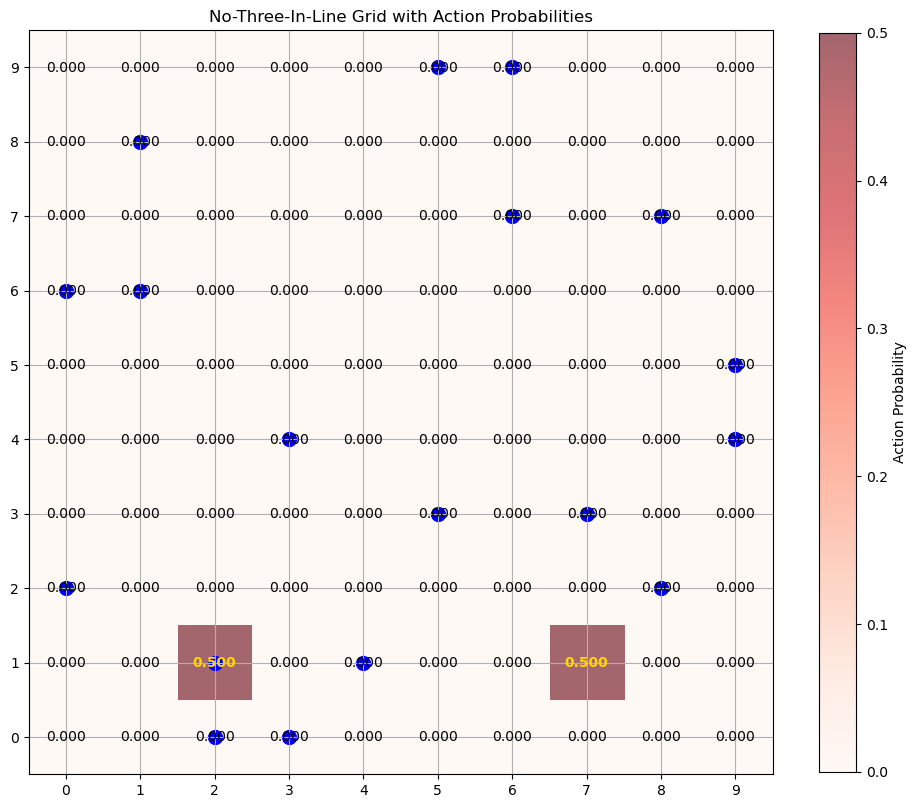

Time: 197.918612 sec


In [2]:
args = {
    'n': 10,
    'C': 1.41, 
    'num_searches': 1000
}

evaluate(args)